## 数据读取


In [18]:
# 导入必要的库
import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# 设置数据路径
BASE_PATH = "memotion_dataset_7k"
IMAGE_PATH = os.path.join(BASE_PATH, "images")
LABELS_PATH = os.path.join(BASE_PATH, "labels.csv")

# 读取标签数据
df_labels = pd.read_csv(LABELS_PATH,index_col=0)

# 读取图像文件
def load_image(image_name):
    try:
        img_path = os.path.join(IMAGE_PATH, image_name)
        img = Image.open(img_path)
        return img
    except Exception as e:
        print(f"Error loading image {image_name}: {str(e)}")
        return None

# 创建图像数据字典
images_dict = {}
for img_name in tqdm(df_labels['image_name'], desc="Loading images"):
    img = load_image(img_name)
    if img is not None:
        images_dict[img_name] = img

print(f"Successfully loaded {len(images_dict)} images")
print(f"Labels shape: {df_labels.shape}")
# 显示标签数据的前几行
print("\nLabels preview:")
print(df_labels.head())


Loading images: 100%|██████████| 6992/6992 [00:02<00:00, 2512.22it/s]

Successfully loaded 6992 images
Labels shape: (6992, 8)

Labels preview:
     image_name                                           text_ocr  \
0   image_1.jpg  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   
1  image_2.jpeg  The best of #10 YearChallenge! Completed in le...   
2   image_3.JPG  Sam Thorne @Strippin ( Follow Follow Saw every...   
3   image_4.png              10 Year Challenge - Sweet Dee Edition   
4   image_5.png  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   

                                      text_corrected      humour  \
0  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   hilarious   
1  The best of #10 YearChallenge! Completed in le...   not_funny   
2  Sam Thorne @Strippin ( Follow Follow Saw every...  very_funny   
3              10 Year Challenge - Sweet Dee Edition  very_funny   
4  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   hilarious   

           sarcasm       offensive      motivational overall_sentiment  
0          general   not

In [25]:
# 去除缺失值
df_labels = df_labels.dropna(subset=["text_corrected", "offensive"])
df_labels["text_corrected"] = df_labels["text_corrected"].astype(str)
print(df_labels.shape)

(6987, 9)


### 文本预处理步骤
1. 添加必要的 NLTK 库
2. 下载必要的资源
3. 创建文本预处理函数
4. 应用预处理并进行分类

In [26]:
# 导入额外的预处理库
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re


In [27]:
# 下载必要的NLTK资源
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\86177\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\86177\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\86177\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\86177\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [28]:
# 创建预处理函数
def preprocess_text(text):
    # 转换为小写
    text = text.lower()
    
    # 移除 URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 移除标点符号
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 分词
    tokens = wordpunct_tokenize(text)
    
    # 去除停用词
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # 重新组合成文本
    return ' '.join(tokens)

## 仅使用文本进行分类

我将帮你创建一个使用简单机器学习模型进行情感分类的代码。我们将使用 scikit-learn 库来实现这个分类任务。这里我们主要关注 `offensive` 这个情感分类标签。

这段代码实现了以下功能：

1. 使用 TF-IDF 将文本转换为特征向量
2. 对情感标签进行编码
3. 将数据集分为训练集和测试集
4. 使用随机森林分类器进行训练
5. 评估模型性能并输出分类报告
6. 展示最重要的特征词
7. 可视化特征词的权重

In [29]:
# 导入必要的库
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [30]:
df_labels['offensive'].value_counts(normalize=True)

offensive
not_offensive        0.387863
slight               0.370832
very_offensive       0.209675
hateful_offensive    0.031630
Name: proportion, dtype: float64

In [31]:
def merge_offensive(label):
    if label in ["slight", "very_offensive",'hateful_offensive']:
        return "offensive"
    else:
        return "not_offensive"
# 合并标签
df_labels['merge_offensive'] = df_labels['offensive'].apply(merge_offensive)

In [32]:
df_labels['merge_offensive'].value_counts(normalize=True)

merge_offensive
offensive        0.612137
not_offensive    0.387863
Name: proportion, dtype: float64

In [33]:
# 数据预处理
# 使用text_corrected作为特征
X = df_labels['text_corrected'].fillna('').apply(preprocess_text)# 填充缺失值
y = df_labels['merge_offensive'] # 目标变量

# 标签编码
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 文本特征提取
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_encoded, test_size=0.2, random_state=42
)

# 训练随机森林分类器
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# 预测和评估
y_pred = rf_classifier.predict(X_test)

# 打印分类报告
print("分类报告：")
print(classification_report(y_test, y_pred, 
                          target_names=le.classes_))

# 查看特征重要性
feature_importance = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': rf_classifier.feature_importances_
})
print("\n最重要的10个特征：")
print(feature_importance.nlargest(10, 'importance'))

分类报告：
               precision    recall  f1-score   support

not_offensive       0.34      0.14      0.20       568
    offensive       0.58      0.81      0.68       830

     accuracy                           0.54      1398
    macro avg       0.46      0.48      0.44      1398
 weighted avg       0.48      0.54      0.48      1398


最重要的10个特征：
           feature  importance
2860          meme    0.005555
2289    imgflipcom    0.005221
2663          like    0.005047
2550          know    0.004184
1751        friend    0.003828
1327          dont    0.003784
2277            im    0.003635
3578  quickmemecom    0.003430
2999         movie    0.003410
1844           get    0.003389


### 增加分类器

In [34]:
# 导入额外的分类器和评估工具
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns

交叉验证结果:
Random Forest: 平均准确率 = 0.563 (+/- 0.014)
Logistic Regression: 平均准确率 = 0.570 (+/- 0.014)
Linear SVC: 平均准确率 = 0.529 (+/- 0.016)
Naive Bayes: 平均准确率 = 0.580 (+/- 0.010)

最佳参数: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}

优化后的分类报告：
               precision    recall  f1-score   support

not_offensive       0.00      0.00      0.00       568
    offensive       0.59      1.00      0.75       830

     accuracy                           0.59      1398
    macro avg       0.30      0.50      0.37      1398
 weighted avg       0.35      0.59      0.44      1398



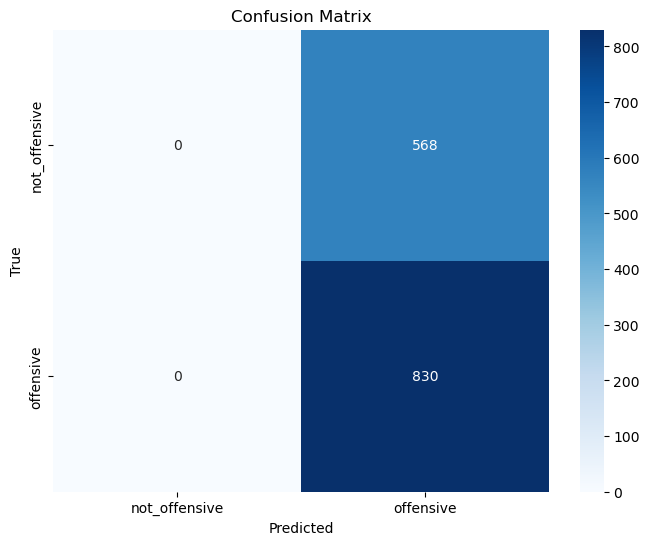

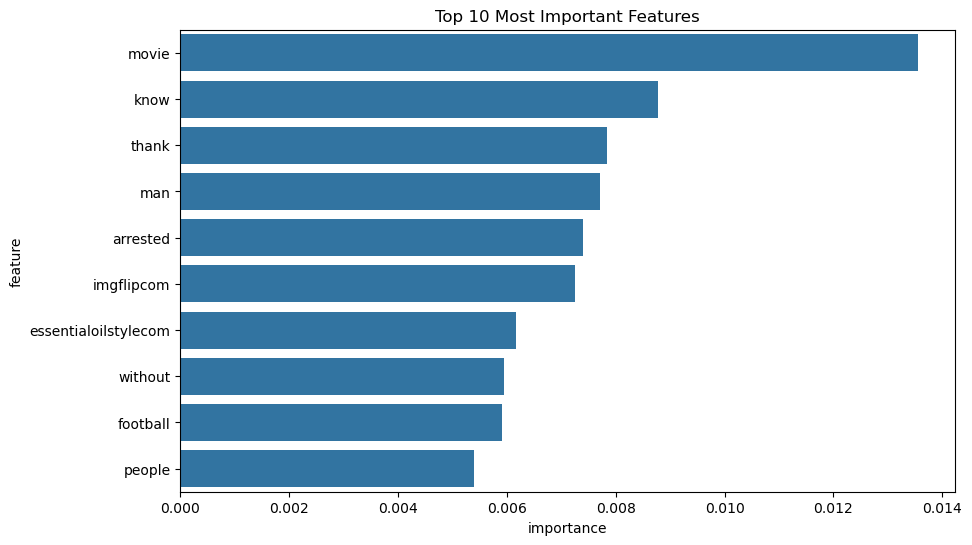

In [35]:
# 使用text_corrected作为特征
X = df_labels['text_corrected'].fillna('').apply(preprocess_text)# 填充缺失值
y = df_labels['merge_offensive'] # 目标变量

# 标签编码
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 文本特征提取
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_encoded, test_size=0.2, random_state=42
)

# 定义多个分类器
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Linear SVC': LinearSVC(random_state=42),
    'Naive Bayes': MultinomialNB()
}

# 对每个分类器进行交叉验证
print("交叉验证结果:")
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_tfidf, y_encoded, cv=5)
    print(f"{name}: 平均准确率 = {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

# 使用网格搜索优化随机森林参数
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("\n最佳参数:", grid_search.best_params_)

# 使用最佳参数的模型
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# 打印分类报告
print("\n优化后的分类报告：")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 特征重要性可视化
feature_importance = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': best_rf.feature_importances_
})
top_features = feature_importance.nlargest(10, 'importance')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.show()

### 观察分类错误的数据

In [9]:
df_read = df_labels[df_labels['offensive'] == "hateful_offensive"]
df_read

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
148,image_149.png,-S6E12 El.can't give this suit back. Ted,S6E12 I can't give this suit back. Ted I glow...,very_funny,not_sarcastic,hateful_offensive,motivational,negative
202,image_203.JPG,PH.D. IN ELECTRICAL ENGINEERING MADE THE WORLD...,PH.D. IN ELECTRICAL ENGINEERING MADE THE WORLD...,not_funny,very_twisted,hateful_offensive,motivational,very_negative
213,image_214.jpg,R.I.P. 1995 - 2016 BBC NEWS,R.I.P. 1995 - 2016 BBC NEWS,very_funny,general,hateful_offensive,not_motivational,neutral
331,image_332.jpg,His arrival was foretold in the ancient murals 2.,His arrival was foretold in the ancient murals,hilarious,very_twisted,hateful_offensive,not_motivational,very_positive
365,image_366.jpg,This is Bill. Bill is an atheist. Bill doesn't...,This is Bill. Bill is an atheist. Bill doesn't...,hilarious,general,hateful_offensive,motivational,positive
...,...,...,...,...,...,...,...,...
6908,image_6909.png,YOU'RE NOT MY REAL DAD spiderman memes,YOU'RE NOT MY REAL DAD spiderman memes 60s spi...,funny,twisted_meaning,hateful_offensive,motivational,negative
6913,image_6914.png,DAD. WHAT'S TAKING THE GAME WINNING SHOT? I DO...,DAD. WHAT'S TAKING THE GAME WINNING SHOT? I DO...,very_funny,general,hateful_offensive,motivational,positive
6915,image_6916.jpg,EUROPE We have to cancel this match Snowing is...,EUROPE We have to cancel this match Snowing is...,very_funny,very_twisted,hateful_offensive,motivational,positive
6935,image_6936.png,. - DC OR MARVEL? MEME MADE BY THE FB PG DC/MA...,. - DC OR MARVEL? MEME MADE BY THE FB PG DC/MA...,funny,twisted_meaning,hateful_offensive,motivational,negative


In [14]:
# 显示图像
images_dict['image_203.JPG'].show()
# 显示文本
print(df_read['text_corrected'].values[1])

PH.D. IN ELECTRICAL ENGINEERING MADE THE WORLD LAUGH WITHOUT SAYING A WORD
